---

## Khmer News Classification with BERT Fine-Tuning Based Approach
---

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
sys.path.append("/content/drive/bert_khmer")

In [ ]:
import re
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

In [ ]:
import tokenization_km
import modeling
import optimization
import run_classifier

In [ ]:
OUTPUT_DIR = "/content/fine_tuned_model"

### Load Pre-trained BERT module for khmer

In [ ]:
!unzip "/content/drive/bert_module_khmer.zip" -d "/content/pretrained"

Archive:  /content/drive/My Drive/Colab Notebooks/Khmer Paper/bert_module_khmer.zip
   creating: /content/pretrained/bert_module_khmer/
   creating: /content/pretrained/bert_module_khmer/assets/
  inflating: /content/pretrained/bert_module_khmer/assets/bert_config.json  
  inflating: /content/pretrained/bert_module_khmer/assets/vocab_file_BERT_.txt  
  inflating: /content/pretrained/bert_module_khmer/saved_model.pb  
  inflating: /content/pretrained/bert_module_khmer/tfhub_module.pb  
   creating: /content/pretrained/bert_module_khmer/variables/
  inflating: /content/pretrained/bert_module_khmer/variables/variables.data-00000-of-00001  
  inflating: /content/pretrained/bert_module_khmer/variables/variables.index  


### Load Data

In [ ]:
data = pd.read_excel('/content/drive/Khmer Paper/news_classification_data_km.xlsx', encoding="UTF-8")

In [ ]:
data.head()

,id,content,tokenized_content,category,category_en
0,45541,រាជធានីភ្នំពេញ ៖នៅក្នុងពិភពសិល្បៈតារាសម្តែងមួយ...,រាជ ធានី ភ្នំ ពេញ ៖ នៅ ក្នុង ពិភព សិល្បៈ តារា ...,សិល្បៈនិងវប្បធម៌,arts-and-culture
1,52071,រាជធានីភ្នំពេញ ៖ ក្រុមតន្ត្រីថ្មីមួយដែលមានឈ្មោ...,រាជ ធានី ភ្នំ ពេញ ៖ ក្រុម តន្ត្រី ថ្មី មួយ ដែល...,សិល្បៈនិងវប្បធម៌,arts-and-culture
2,8906,រូបកាយយើងនេះញាំញីទៅដោយជំងឺដង្កាត់គ្រប់ប្រភេទ អ...,រូប កាយ យើង នេះ ញាំញី ទៅ ដោយ ជំងឺ ដង្កាត់ គ្រប...,សិល្បៈនិងវប្បធម៌,arts-and-culture
3,49697,រាជធានីភ្នំពេញ ៖ តារាសម្តែង និងជាអ្នកចម្រៀងវ័យ...,រាជ ធានី ភ្នំ ពេញ ៖ តារា សម្តែង និង ជា អ្នក ចម...,សិល្បៈនិងវប្បធម៌,arts-and-culture
4,46696,រាជធានីភ្នំពេញ ៖ អ្នកនាងឡាយ លក្ខិណា ក្រោយពេលវិ...,រាជ ធានី ភ្នំ ពេញ ៖ អ្នក នាង ឡាយ លក្ខិណា ក្រោយ...,សិល្បៈនិងវប្បធម៌,arts-and-culture


### Preprocessing

In [ ]:
data['tokenized_content'] = data['tokenized_content'].apply(lambda x: ' '.join(re.sub(r'[០១២៣៤៥៦៧៨៩។៕៖ៗ៘៙៚]+', ' ', x).strip().split()))
data.drop_duplicates(subset=['tokenized_content'], inplace=True)

In [ ]:
data.shape

(7418, 5)

In [ ]:
data.category_en.unique()

array(['arts-and-culture', 'sports-news', 'business',
       'international-news', 'national-news', 'research', 'service',
       'health'], dtype=object)

In [ ]:
data['category_en'].value_counts()

research              999
international-news    999
health                999
national-news         999
arts-and-culture      998
service               994
sports-news           769
business              661
Name: category_en, dtype: int64

In [ ]:
## Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label'] = le.fit_transform(data.loc[:, 'category_en'].copy().tolist())

In [ ]:
data[['category_en', 'label']].drop_duplicates(subset=['category_en']).sort_values(by=['label']).reset_index(drop=True)

,category_en,label
0,arts-and-culture,0
1,business,1
2,health,2
3,international-news,3
4,national-news,4
5,research,5
6,service,6
7,sports-news,7


In [ ]:
data.head()

,id,content,tokenized_content,category,category_en,label
0,45541,រាជធានីភ្នំពេញ ៖នៅក្នុងពិភពសិល្បៈតារាសម្តែងមួយ...,រាជ ធានី ភ្នំ ពេញ នៅ ក្នុង ពិភព សិល្បៈ តារា សម...,សិល្បៈនិងវប្បធម៌,arts-and-culture,0
1,52071,រាជធានីភ្នំពេញ ៖ ក្រុមតន្ត្រីថ្មីមួយដែលមានឈ្មោ...,រាជ ធានី ភ្នំ ពេញ ក្រុម តន្ត្រី ថ្មី មួយ ដែល ម...,សិល្បៈនិងវប្បធម៌,arts-and-culture,0
2,8906,រូបកាយយើងនេះញាំញីទៅដោយជំងឺដង្កាត់គ្រប់ប្រភេទ អ...,រូប កាយ យើង នេះ ញាំញី ទៅ ដោយ ជំងឺ ដង្កាត់ គ្រប...,សិល្បៈនិងវប្បធម៌,arts-and-culture,0
3,49697,រាជធានីភ្នំពេញ ៖ តារាសម្តែង និងជាអ្នកចម្រៀងវ័យ...,រាជ ធានី ភ្នំ ពេញ តារា សម្តែង និង ជា អ្នក ចម្រ...,សិល្បៈនិងវប្បធម៌,arts-and-culture,0
4,46696,រាជធានីភ្នំពេញ ៖ អ្នកនាងឡាយ លក្ខិណា ក្រោយពេលវិ...,រាជ ធានី ភ្នំ ពេញ អ្នក នាង ឡាយ លក្ខិណា ក្រោយ ព...,សិល្បៈនិងវប្បធម៌,arts-and-culture,0


### Data Partitioning

In [ ]:
X = data['tokenized_content']
y = data['label']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1234, shuffle=True, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3, random_state=1234, shuffle=True, stratify=y_val)

print("""Training shape: {}
Validation shape: {}
Testing shape: {}""".format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

Training shape: 5192
Validation shape: 1558
Testing shape: 668


In [ ]:
train = pd.DataFrame({'news': X_train, 'label': y_train})
val = pd.DataFrame({'news': X_val, 'label': y_val})
test = pd.DataFrame({'news': X_test, 'label': y_test})

### Create InputExample

In [ ]:
DATA_COLUMN = 'news'
LABEL_COLUMN = 'label'
label_list = [0, 1, 2, 3, 4, 5, 6, 7]

In [ ]:
train_InputExamples = train.apply(lambda x: run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val.apply(lambda x: run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

### Tokenizer

In [ ]:
vocab_path = '/content/pretrained/bert_module_khmer/assets/vocab_file_BERT_.txt'
tokenizer = tokenization_km.FullTokenizer(vocab_file=vocab_path, do_lower_case=True)

### Feature Extraction

In [ ]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
train_features = run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
val_features = run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)


INFO:tensorflow:Writing example 0 of 5192
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: None
INFO:tensorflow:tokens: [CLS] ប្រទេស សិង្ហបុរី BuildTech Yangon គឺ ជា ការ តាំង ពិព័រណ៍ ពាណិជ្ជ កម្ម ដែល ប្លែក ពី គេ សម្រាប់ ការ អភិវឌ្ឍ វិស័យ អគារ និង សំណង់ ហើយ ឆ្នាំ នេះ ការ តាំង ពិព័រណ៍ ដ៏ ធំ មួយ នឹង ចាប់ ពី ថ្ងៃ ទី ដល់ ថ្ងៃ ទី មេសា ឆ្នាំ នៅ មជ្ឈមណ្ឌល សន្និបាត ប្រទេស មីយ៉ាន់ម៉ា ក្នុង ទីក្រុង Yangon ពិព័រណ៍ នេះ រៀបចំ ដោយ ក្រុមហ៊ុន Sphere Exhibits សាខា នៃ អង្គភាព សារ ព័ត៌មាន សិង្ហបុរី និង រៀបចំ រួម គ្នា ដោយ សមាគម សហគ្រិន សំណង់ មីយ៉ាន់ម៉ា ក្នុង គោល បំណង ជួយ អភិវឌ្ឍន៍ វិស័យ សំណង់ របស់ ប្រទេស មីយ៉ាន់ម៉ា ផ្ដោត ការ យក ចិត្ត ទុក ដាក់ លើ ហេដ្ឋា រចនា សម្ព័ន្ធ អគារ ស្នាក់ នៅ និង អគារ ពាណិជ្ជ កម្ម ការ ដឹក ជញ្ជូន ការ ផលិត និង ការ ធ្វើ ជំនួញ លើស ពី នេះ ទៀត ការ តាំង ពិព័រណ៍ នេះ នឹង មាន រៀបចំ សិក្ខា សាលា ស្ដី ពី អាជីវកម្ម និង វគ្គ សិក្សា [SEP]
INFO:tensorflow:input_ids: 0 22145 107962 165253 30214 125739 16100 152009 33813 40265 118713 84262 28613 85966 29168 85779 26142 152009 153373 105448 153362 

### Create Classification model

In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels, num_labels):
  """Creates a classification model."""

  bert_module = hub.Module("./pretrained/bert_module_khmer", trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value


  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

### Creating Model Function

In [ ]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        # f1_score = tf.contrib.metrics.f1_score(label_ids, predicted_labels)
        # auc = tf.metrics.auc(label_ids, predicted_labels)
        # recall = tf.metrics.recall(label_ids, predicted_labels)
        # precision = tf.metrics.precision(label_ids, predicted_labels)
        return {
            "eval_accuracy": accuracy
            # "f1_score": f1_score,
            # "auc": auc,
            # "precision": precision,
            # "recall": recall
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [ ]:
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3
WARMUP_PROPORTION = 0.5
SAVE_CHECKPOINTS_STEPS = int(len(train_features) / BATCH_SIZE)
SAVE_SUMMARY_STEPS = 100

In [ ]:
# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [ ]:
# Specify outpot directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    keep_checkpoint_max = 8)

In [ ]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '/content/fine_tuned_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 162, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 8, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe6d8533198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

### Training

In [ ]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /content/fine_tuned_model/model.ckpt.
INFO:tensorflow:loss = 2.2340796, step = 0
INFO:tensorflow:global_step/sec: 1.42802
INFO:tensorflow:loss = 0.690549, step = 100 (70.028 sec)
INFO:tensorflow:Saving checkpoints for 162 into /content/fine_tuned_model/model.ckpt.
INFO:tensorflow:global_step/sec: 1.18289
INFO:tensorflow:loss = 0.34586555, step = 200 (84.539 sec)
INFO:tensorflow:global_step/sec: 1.95684
INFO:tensorflow:loss = 0.28952712, step = 300 (51.102 sec)
INFO:tensorflow:Saving checkpoints for 324 into /content/fine_tuned_model/model.ckpt.
INFO:tensorflow:global_step/sec: 1.21048
INFO:tensorflow:loss = 0.21067086, step = 400 (82.612 sec)
INFO:tensorflow:Saving checkpoints for 486 into /content/fine_tuned_model/model.ckpt.
INFO:tensorflo

### Training_accuracy

In [ ]:
test_input_fn_with_train_data = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
train_result = []
for i in [162, 324,486]:
# for i in range(200, 1100, 100):
    train_acc = estimator.evaluate(input_fn=test_input_fn_with_train_data, steps=None,
                    checkpoint_path='./fine_tuned_model/model.ckpt-' + str(i))
    train_result.append(train_acc)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-23T05:16:21Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./fine_tuned_model/model.ckpt-162
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-08-23-05:16:53
INFO:tensorflow:Saving dict for global step 162: eval_accuracy = 0.8896379, global_step = 162, loss = 0.3536357
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 162: ./fine_tuned_model/model.ckpt-162
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-23T05:17:07Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./fine_tuned_model/model.ckpt-324
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-08-23-05:17:39
INFO:tensorflow:Saving dict for global step 324: eval_accuracy = 0.9395223, global_step = 324, loss = 0.20062038
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 324: ./fine_tuned_model/model.ckpt-324
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-23T05:17:52Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./fine_tuned_model/model.ckpt-486
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-08-23-05:18:24
INFO:tensorflow:Saving dict for global step 486: eval_accuracy = 0.9666795, global_step = 486, loss = 0.117473945
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 486: ./fine_tuned_model/model.ckpt-486


### Validation_accuracy:

In [ ]:
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
val_result = []
for i in [162, 324,486]:   
    val_acc = estimator.evaluate(input_fn=val_input_fn, steps=None, 
                                checkpoint_path='./fine_tuned_model/model.ckpt-' + str(i))
    val_result.append(val_acc)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-23T05:18:40Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./fine_tuned_model/model.ckpt-162
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-08-23-05:18:55
INFO:tensorflow:Saving dict for global step 162: eval_accuracy = 0.84724003, global_step = 162, loss = 0.48121017
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 162: ./fine_tuned_model/model.ckpt-162
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-23T05:19:07Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./fine_tuned_model/model.ckpt-324
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-08-23-05:19:21
INFO:tensorflow:Saving dict for global step 324: eval_accuracy = 0.85109115, global_step = 324, loss = 0.45876718
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 324: ./fine_tuned_model/model.ckpt-324
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-08-23T05:19:33Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./fine_tuned_model/model.ckpt-486
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-08-23-05:19:48
INFO:tensorflow:Saving dict for global step 486: eval_accuracy = 0.8684211, global_step = 486, loss = 0.44165662
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 486: ./fine_tuned_model/model.ckpt-486


### Prediction

In [ ]:
def getPrediction(in_sentences):
  labels = [0, 1, 2, 3, 4, 5, 6, 7]
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences]
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn, 
                                  checkpoint_path="./fine_tuned_model/model.ckpt-162")
  return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [ ]:
pred_sentences = X_test.to_list()
predictions = getPrediction(pred_sentences)

INFO:tensorflow:Writing example 0 of 668
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: 
INFO:tensorflow:tokens: [CLS] រាជ ធានី ភ្នំ ពេញ ដោយ ឈរ លើ ស្មារតី នៃ កិច្ច សហ ប្រតិបត្តិការ រវាង ប្រទេស ទាំង ពីរ កម្ពុជា - ជប៉ុន សំខាន់ កិច្ច សហ ប្រតិបត្តិការ លើ វិស័យ ទេសចរណ៍ នេះ ប្រទេស ជប៉ុន នឹង រៀបចំ ឲ្យ មាន ជើង ហោះ ហើរ ដោយ ត្រង់ មក កម្ពុជា រយៈ ពេល ដ៏ ខ្លី ខាង មុខ នេះ ថ្លែង នៅ ក្នុង សន្និសីទ កាសែត ស្តី ពី ជើង ហោះ ហើរ ដោយ ត្រង់ ជា ប្រចាំ លើក ដំបូង កម្ពុជា - ជប៉ុន នៅ ថ្ងៃ ទី មិថុនា នៅ ទីស្តីការ ក្រសួង ទេសចរណ៍ លោក ថោង ខុន រដ្ឋ មន្ត្រី ក្រសួង ទេសចរណ៍ បាន បញ្ជាក់ ថា នៅ ថ្ងៃ ទី កញ្ញា នេះ ជប៉ុន នឹង មាន ជើង ហោះ ហើរ ដោយ ត្រង់ មក កម្ពុជា ជា លើក ដំបូង តាម រយៈ ក្រុមហ៊ុន Asia Atlantic Airlines លោក ថោង ខុន មាន ប្រសាសន៍ ថា ប្រទេស ជប៉ុន និង កម្ពុជា បាន ភ្ជាប់ កិច្ច សហ ប្រតិបត្តិការ ជាមួយ គ្នា ចាប់ [SEP]
INFO:tensorflow:input_ids: 0 46225 8634 38431 90697 67734 162859 20394 116905 72073 106053 12023 131359 53368 22145 39376 137792 165324 2 87847 96442 106053 12023 131359 20394 105448 126665 28801 22145 87

In [ ]:
y_actual = y_test.tolist()
y_pred = [i[2] for i in predictions]
result_df = pd.DataFrame({'actual': y_actual, 'pred':y_pred})

### Result Analysis

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
test_result = accuracy_score(y_actual, y_pred)
print("Accuracy:", test_result)

Accuracy: 0.8458083832335329


In [ ]:
pd.DataFrame([train_result[0]['eval_accuracy'], val_result[0]['eval_accuracy'], test_result],
              index = ['Training', 'Validation', 'Test'],
              columns = ['Accuracy'])

,Accuracy
Training,0.889638
Validation,0.847240
Test,0.845808


In [ ]:
## generate confusion matrix
cm = confusion_matrix(y_actual, y_pred)
p = pd.DataFrame(cm, 
                 index = list(le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7])),
                 columns = list(le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7])))
p.style.set_properties(**{'background-color': 'skyblue', 
                          'color': 'black'})

,arts-and-culture,business,health,international-news,national-news,research,service,sports-news
arts-and-culture,82,0,1,0,3,2,2,0
business,0,49,0,1,2,5,2,0
health,0,0,83,0,2,5,0,0
international-news,0,1,1,75,0,12,1,0
national-news,1,4,0,2,80,2,0,1
research,0,3,15,8,0,62,2,0
service,3,0,12,0,2,3,68,2
sports-news,0,0,0,1,0,1,1,66


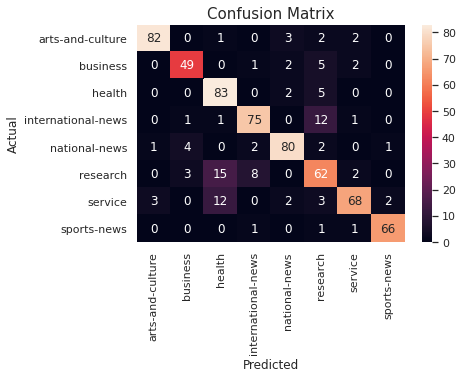

In [ ]:
## Confusion Matrix in Heatmap
import matplotlib.pyplot as plt
import seaborn as sns
# plt.figure(figsize=(12, 8))
sns.set()
f = sns.heatmap(p, annot=True)
plt.title("Confusion Matrix", fontdict={'fontsize': 15})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# f.get_figure().savefig("news_confusion_matrix_fine_tune.jpg", dpi=300, bbox_inches='tight')

In [ ]:
## Classification Report
target_names = list(le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7]))
print(classification_report(y_actual, y_pred, target_names = target_names))

                    precision    recall  f1-score   support

  arts-and-culture       0.95      0.91      0.93        90
          business       0.86      0.83      0.84        59
            health       0.74      0.92      0.82        90
international-news       0.86      0.83      0.85        90
     national-news       0.90      0.89      0.89        90
          research       0.67      0.69      0.68        90
           service       0.89      0.76      0.82        90
       sports-news       0.96      0.96      0.96        69

          accuracy                           0.85       668
         macro avg       0.86      0.85      0.85       668
      weighted avg       0.85      0.85      0.85       668

